# UCI heart disease 데이터를 이용한 심장병 예측 프로젝트

UCI 데이터 저장소의 심장병 데이터 세트<br>
제작자:
- 헝가리 심장학 연구소. 부다페스트: Andras Janosi, MD
- 스위스 취리히 대학 병원: 윌리엄 슈타인브룬 박사
- 스위스 바젤 대학병원: Matthias Pfisterer, MD
- VA 의료 센터, 롱비치 및 클리블랜드 클리닉 재단: 로버트 디트라노, MD, Ph.D.

출처 : https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data

In [1]:
from pyspark.sql import SparkSession
MAX_MEMORY = '8g'
spark = SparkSession.builder.appName("Heart_disease")\
                .config('spark.driver.memory',MAX_MEMORY)\
                .config('spark.executor.memory', MAX_MEMORY)\
                .getOrCreate()

# 0. 라이브러리 불러오기 

In [2]:
# PySpark 및 Spark 세션
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import rand
# 데이터 처리
import pandas as pd   
import numpy as np    

# 시각화 
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark MLlib 
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# 1. 데이터 불러오기

In [3]:
df = spark.read.csv('file:////home/jovyan/work/practice_virtual-environment/Heart_disease/heart_disease_uci.csv'
    , inferSchema=True, header=True)

In [4]:
df.toPandas()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,None,NaN,None,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,None,NaN,None,NaN,None,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,None,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,None,NaN,None,NaN,None,0


열 설명 <br>
id : (환자마다 고유 ID)<br>
age : (환자의 나이)<br>
sex : (남자/여자)<br>
cp : 흉통 유형([전형적 협심증, 비정형 협심증, 비협심증, 무증상])<br>
trestbps : 안정시 혈압(입원 시 안정시 혈압(mmHg))<br>
chol : (혈청 콜레스테롤 mg/dl)<br>
fbs : (공복혈당 > 120 mg/dl인 경우)<br>
restecg : (휴식기 심전도 결과)-- 값: [정상, 정상 이상, 좌심실 비대]<br>
thalach: 최대 심박수 달성<br>
exang: 운동 유발 협심증 (참/거짓)<br>
oldpeak: 휴식에 비해 운동으로 인한 ST 저하<br>
slope: 최대 운동 ST 분절의 기울기<br>
ca: 투시를 통해 채색된 주요 혈관 수(0-3)<br>
thal: [정상; 고정 결함; 가역 결함]<br>
num: 타겟

# 2. 데이터 EDA & 전처리

In [5]:
# 불필요한 데이터인 id, dataset제거 
df = df.drop('id','dataset') 

In [6]:
# 결측치 확인(데이터의 양이 너무 크지 않기에 판다스로 변환해서 결측치 확인)
Hc_pd = df.toPandas()
print(Hc_pd.isnull().sum())

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


thal, ca, slope는 920row중 30%이상의 결측치 확인, <br>
drop을 통해 제거 

In [7]:
df = df.drop('thal','ca','slope') 

In [8]:
Hc_pd1 = df.toPandas()
print(Hc_pd1.isnull().sum())

age          0
sex          0
cp           0
trestbps    59
chol        30
fbs         90
restecg      2
thalch      55
exang       55
oldpeak     62
num          0
dtype: int64


남은 결측치 보유 컬럼 : trestbps, chol, fbs, restecg, thalch, exang, oldpeak<br>
문자열 데이터 : fbs, restecg, exang

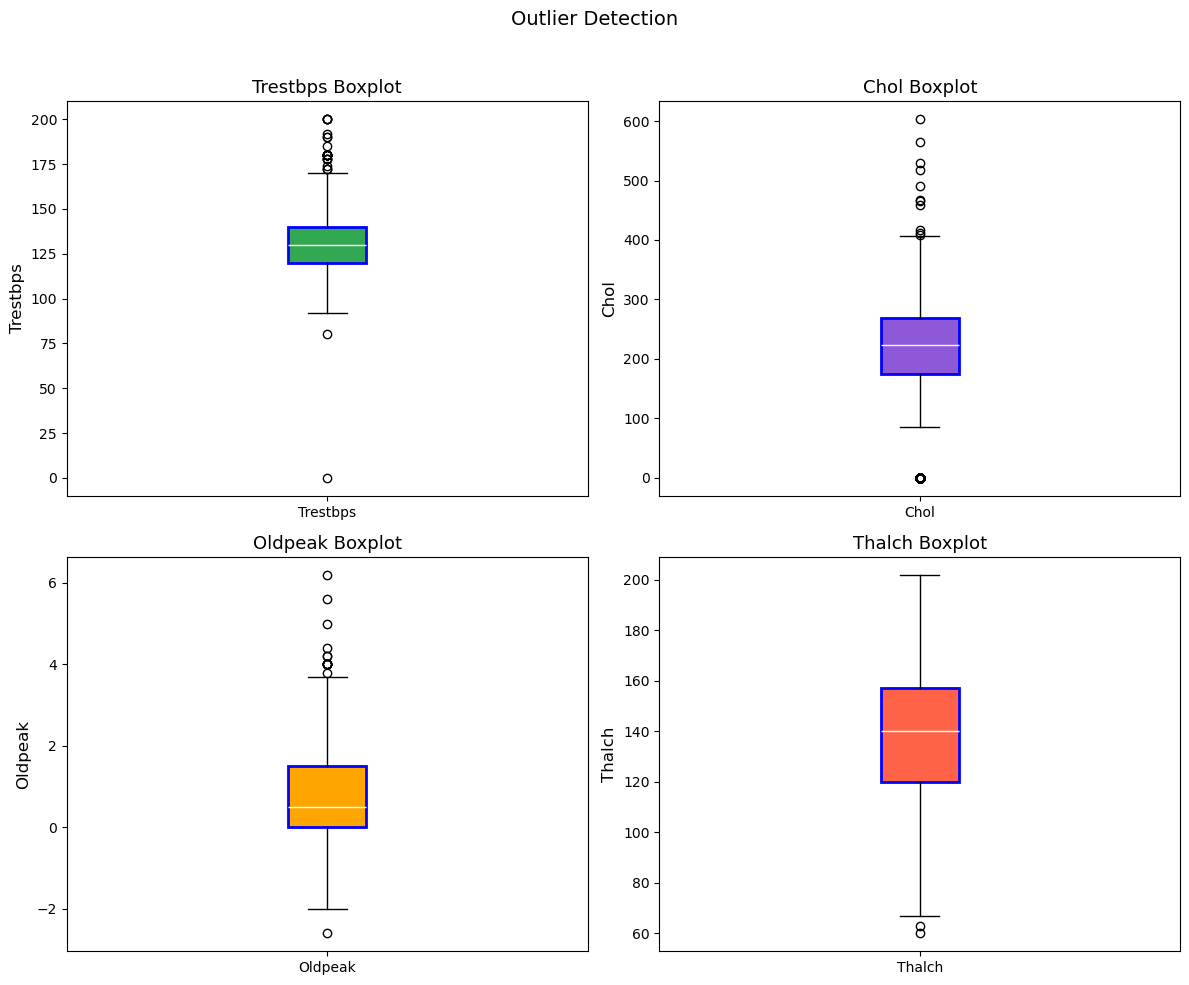

In [9]:
trestbps_data = Hc_pd1['trestbps'].dropna().values
chol_data     = Hc_pd1['chol'].dropna().values
oldpeak_data  = Hc_pd1['oldpeak'].dropna().values
thalch_data   = Hc_pd1['thalch'].dropna().values

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# trestbps
axes[0, 0].boxplot(trestbps_data, patch_artist=True,
                   boxprops=dict(facecolor='#32a852', color='blue', linewidth=2),
                   medianprops=dict(color='white'))
axes[0, 0].set_title('Trestbps Boxplot', fontsize=13)
axes[0, 0].set_ylabel('Trestbps', fontsize=12)
axes[0, 0].set_xticklabels(['Trestbps'])

# chol
axes[0, 1].boxplot(chol_data, patch_artist=True,
                   boxprops=dict(facecolor='#8e59d9', color='blue', linewidth=2),
                   medianprops=dict(color='white'))
axes[0, 1].set_title('Chol Boxplot', fontsize=13)
axes[0, 1].set_ylabel('Chol', fontsize=12)
axes[0, 1].set_xticklabels(['Chol'])

# oldpeak
axes[1, 0].boxplot(oldpeak_data, patch_artist=True,
                   boxprops=dict(facecolor='#ffa500', color='blue', linewidth=2),
                   medianprops=dict(color='white'))
axes[1, 0].set_title('Oldpeak Boxplot', fontsize=13)
axes[1, 0].set_ylabel('Oldpeak', fontsize=12)
axes[1, 0].set_xticklabels(['Oldpeak'])

# thalch
axes[1, 1].boxplot(thalch_data, patch_artist=True,
                   boxprops=dict(facecolor='#ff6347', color='blue', linewidth=2),
                   medianprops=dict(color='white'))
axes[1, 1].set_title('Thalch Boxplot', fontsize=13)
axes[1, 1].set_ylabel('Thalch', fontsize=12)
axes[1, 1].set_xticklabels(['Thalch'])

fig.suptitle('Outlier Detection', fontsize=14)
fig.set_facecolor('white')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

박스플롯을 통해 수치형 변수들의 이상치, 평균등을 확인,<br>
이상치가 많다고 관측되었지만 의학적인 관점에선 이상치라 판단하긴 어려움<br>
혈압trestbps같은 경우 고혈압 환자인 경우를 감안하면 이상치라 판단 어려움<br>
콜레스테롤chol같은 경우 당뇨 환자인 경우를 감안하면 이상치라 판단 어려움<br>
최대심박수thalch같은 경우 운동 후, 나이등을 감안하면 이상치라 판단 어려움<br>
운동 후 ST저하로 oldpeak같은 경우에도 심질환 환자임을 감안하면 이상치라 판단 어려움

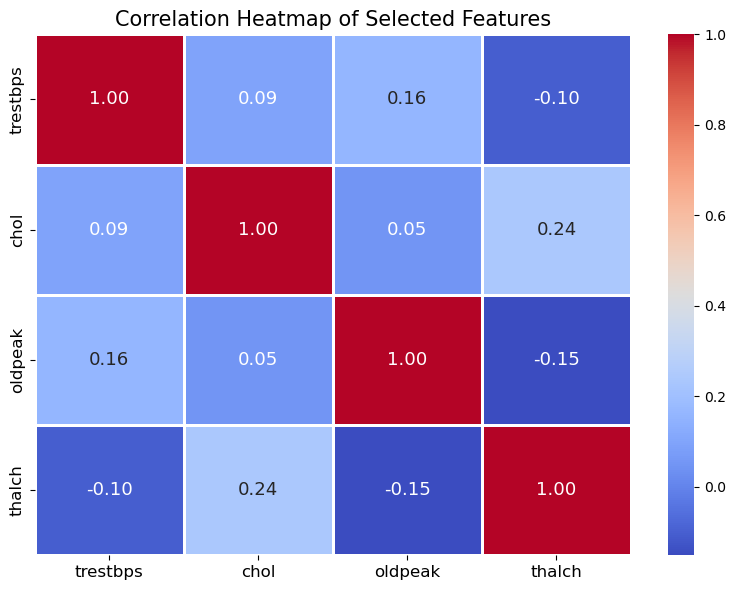

In [10]:
# 상관분석 대상 칼럼
cols = ['trestbps', 'chol', 'oldpeak', 'thalch']
corr_df = Hc_pd1[cols]

# 상관관계 분석
corr_matrix = corr_df.corr()

# 히트맵 
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=2, cbar=True,
            annot_kws={'size':13})
plt.title('Correlation Heatmap of Selected Features', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


4가지 변수 다 심장질환과의 연관되어 있어 히트맵을 통해 상관계수를 구해 상관계수가 높은것에 한해,<br>
KNN기법을 사용해 결측치를 처리하려 했지만 서로 상관관계가 매우 미미하다고 나와 KNN기법이아닌,<br>1
중앙값을 이용해 결측치 처리

In [11]:
# 4가지 변수 전처리 
num_cols = ['trestbps', 'chol', 'thalch', 'oldpeak']

for col in num_cols:
    median_val = df.approxQuantile(col, [0.5], 0.01)[0]
    df = df.fillna({col: median_val})

In [12]:
Hc_pd2 = df.toPandas()
print(Hc_pd2.isnull().sum())

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs         90
restecg      2
thalch       0
exang       55
oldpeak      0
num          0
dtype: int64


남은 결측치인 fbs, restecg, exang같은 경우 문자열 데이터이기에 가장 흔히 쓰인는 최빈값으로 대체

In [13]:
# 문자열 데이터 3가지 결측치 처리
for s_col in ['exang', 'fbs', 'restecg']:
    mode_val = df.groupBy(s_col).count().orderBy('count', ascending=False).first()[0]
    df = df.fillna({s_col: mode_val})

In [14]:
Hc_pd3 = df.toPandas()
print(Hc_pd3.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64


age, sex, cp, num 이상치 확인 (결측치가 없어 이상치 확인을 안한 데이터들) 
하지만 sex, cp는 문자열 데이터 num과 같은 경우 타겟 변수로 0,1,2,3,4로만 구성 

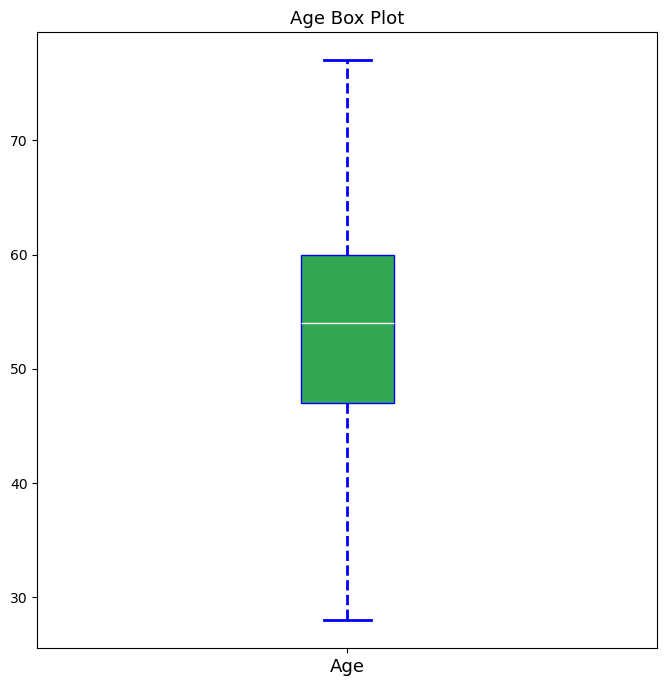

In [15]:
age_data = Hc_pd3['age'].dropna().values 

edgecolor = 'blue'        
linewidth = 2             
facecolors = ['#32a852']    
medianlinecolor = 'white'  

fig = plt.figure(figsize=(8, 8))           
fig.set_facecolor('white')                   

box = plt.boxplot([age_data], patch_artist=True)

for item in ['boxes', 'fliers', 'medians']:
    for i, v in enumerate(box[item]):
        if item == 'boxes':
            plt.setp(v, facecolor=facecolors[i], edgecolor=edgecolor)
        elif item == 'fliers':
            plt.setp(v, markerfacecolor=facecolors[i])
        else:
            plt.setp(v, color=medianlinecolor)

for item in ['whiskers', 'caps']:
    for i, v in enumerate(zip(box[item][::2], box[item][1::2])):
        if item == 'whiskers':
            plt.setp(v, color=edgecolor, linewidth=linewidth, linestyle='--')
        else:
            plt.setp(v, color=edgecolor, linewidth=linewidth)

plt.xticks([1], ['Age'], fontsize=13)      
plt.title('Age Box Plot', fontsize=13)    

plt.show()

Age에 이상치가 없음을 확인 Age와 결측치를 처리했던 수치형 변수들의 분포도를 EDA를 통해 확인

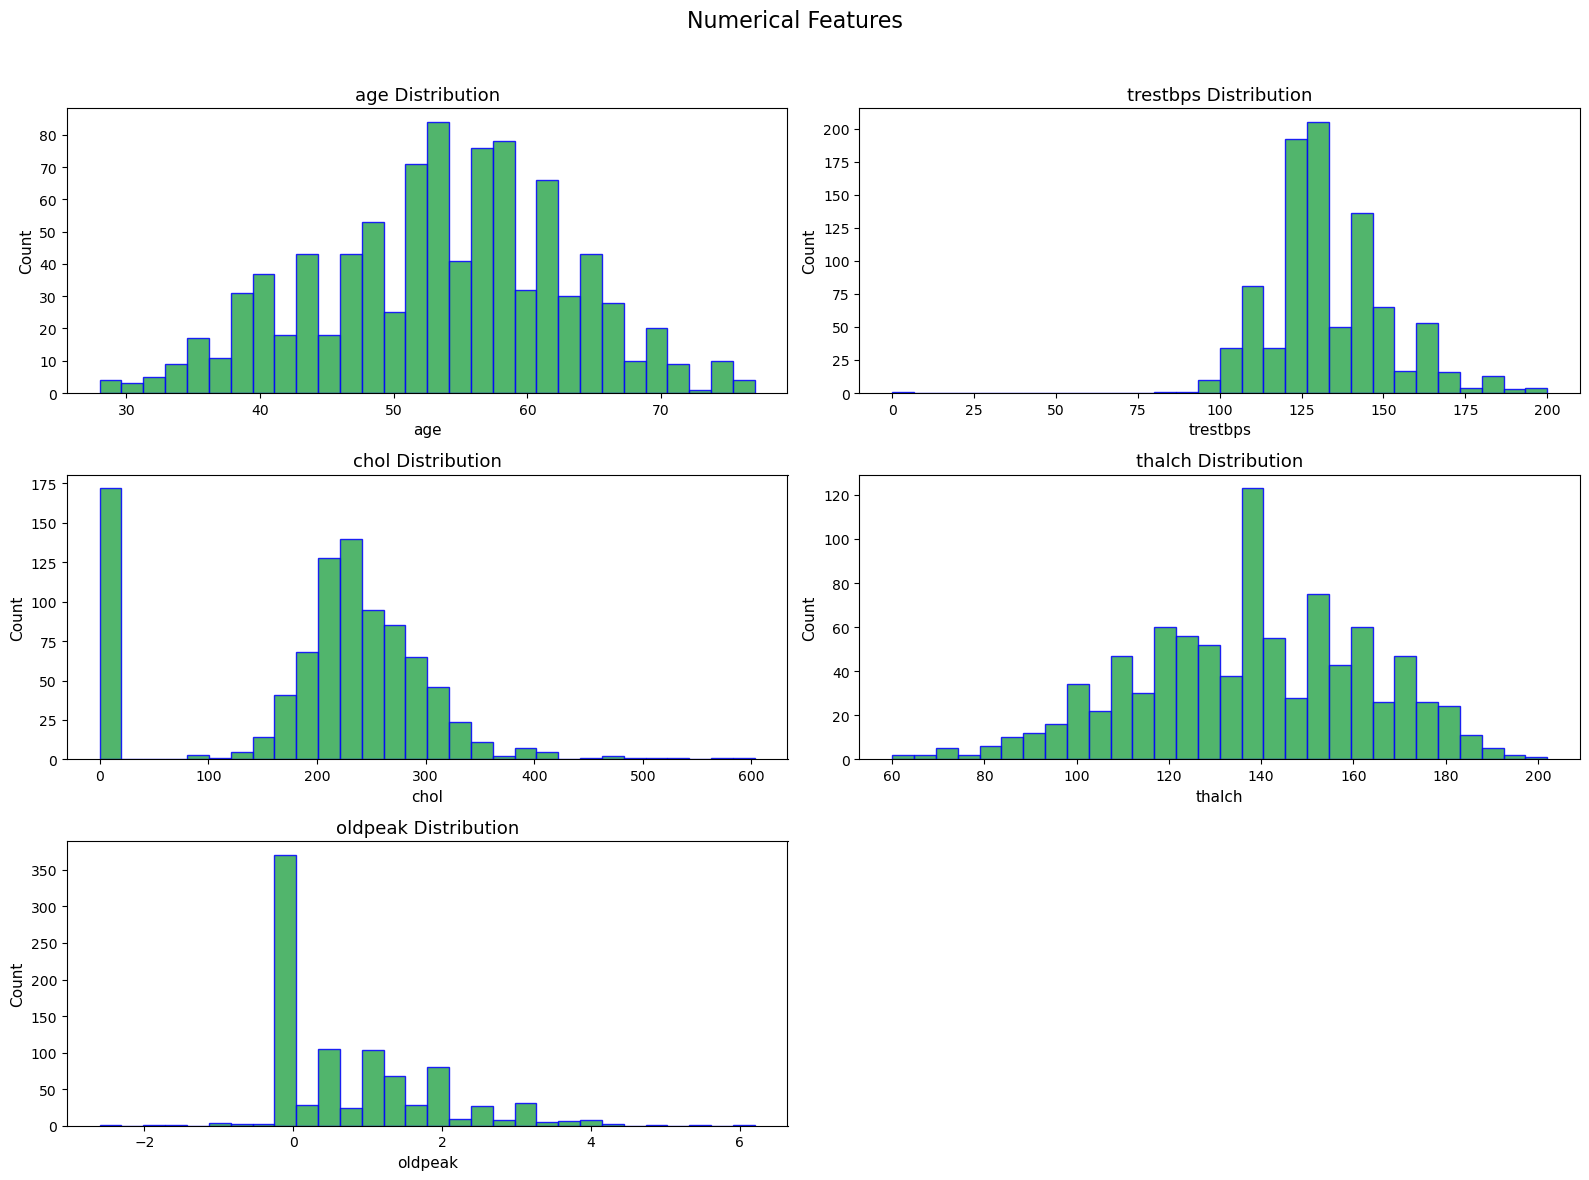

In [16]:
num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
data_list = [Hc_pd3[col].dropna().values for col in num_cols]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

for i, (col, data) in enumerate(zip(num_cols, data_list)):
    row, col_idx = divmod(i, 2)
    axes[row, col_idx].hist(data, color='#32a852', edgecolor='blue', alpha=0.85, bins=30)
    axes[row, col_idx].set_title(f'{col} Distribution', fontsize=13)
    axes[row, col_idx].set_xlabel(col, fontsize=11)
    axes[row, col_idx].set_ylabel('Count', fontsize=11)

fig.delaxes(axes[2, 1])

fig.suptitle('Numerical Features', fontsize=16)
fig.set_facecolor('white')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

5가지의 수치형 변수들의 분포를 히스토그램으로 확인해본 결과 oldpeak을 제외하고 전부 정상이라고 판단<br>
하지만 의료데이터임을 감안, 또한 극단적 이상값 또는 왜곡된 값이 없다고 판단해 5가지 변수 전부 변환 없이 진행

In [17]:
df.show(3)

+---+----+--------------+--------+----+-----+--------------+------+-----+-------+---+
|age| sex|            cp|trestbps|chol|  fbs|       restecg|thalch|exang|oldpeak|num|
+---+----+--------------+--------+----+-----+--------------+------+-----+-------+---+
| 63|Male|typical angina|     145| 233| true|lv hypertrophy|   150|false|    2.3|  0|
| 67|Male|  asymptomatic|     160| 286|false|lv hypertrophy|   108| true|    1.5|  2|
| 67|Male|  asymptomatic|     120| 229|false|lv hypertrophy|   129| true|    2.6|  1|
+---+----+--------------+--------+----+-----+--------------+------+-----+-------+---+
only showing top 3 rows



In [18]:
Hc_pd3['cp'].value_counts(dropna=False)

cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

In [19]:
Hc_pd3['fbs'].value_counts(dropna=False)

fbs
False    782
True     138
Name: count, dtype: int64

In [20]:
Hc_pd3['restecg'].value_counts(dropna=False)

restecg
normal              553
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64

In [21]:
Hc_pd3['exang'].value_counts(dropna=False)

exang
False    583
True     337
Name: count, dtype: int64

exang, fbs의 경우 단순 True, False임으로 원 - 핫 인코딩을 진행 <br>
restecg의 경우 심전도 결과로 정상, 정상 이상, 좌심실 비대으로 각각 가중치를 부여해 수치형 변환<br>
cp의 경우 무증상과 기타 심질환으로 분류하여 이진 변수 생성

In [24]:
from pyspark.sql.functions import col #(자꾸 오류가 발생해 셀 자체에 추가)
df = df.withColumn('exang', col('exang').cast('int'))
df = df.withColumn('fbs', col('fbs').cast('int'))

# 원 - 핫 인코딩 
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in ['exang', 'fbs']]
encoder = OneHotEncoder(inputCols=['exang_idx', 'fbs_idx'],
                        outputCols=['exang_oh', 'fbs_oh'])

pipeline = Pipeline(stages=indexers + [encoder])
model = pipeline.fit(df)
df = model.transform(df)

In [25]:
# 가중치 처리 
df = df.withColumn(
    "restecg_score",
    when(col("restecg") == "normal", 0)
    .when(col("restecg") == "lv hypertrophy", 1)
    .when(col("restecg") == "st-t abnormality", 2)
    .otherwise(None) 
)

In [26]:
# cp 무증상/ 기타 이진 변수 
df = df.withColumn(
    "cp_asymptomatic",
    when(col("cp") == "asymptomatic", 1).otherwise(0)
)

In [27]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = false)
 |-- restecg: string (nullable = false)
 |-- thalch: integer (nullable = true)
 |-- exang: integer (nullable = false)
 |-- oldpeak: double (nullable = false)
 |-- num: integer (nullable = true)
 |-- exang_idx: double (nullable = false)
 |-- fbs_idx: double (nullable = false)
 |-- exang_oh: vector (nullable = true)
 |-- fbs_oh: vector (nullable = true)
 |-- restecg_score: integer (nullable = true)
 |-- cp_asymptomatic: integer (nullable = false)



In [28]:
# 미처 인코딩 하지 못한 sex컬럼 인코딩 
indexer = StringIndexer(inputCol="sex", outputCol="sex_index", handleInvalid="keep")
df = indexer.fit(df).transform(df)

In [29]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = false)
 |-- restecg: string (nullable = false)
 |-- thalch: integer (nullable = true)
 |-- exang: integer (nullable = false)
 |-- oldpeak: double (nullable = false)
 |-- num: integer (nullable = true)
 |-- exang_idx: double (nullable = false)
 |-- fbs_idx: double (nullable = false)
 |-- exang_oh: vector (nullable = true)
 |-- fbs_oh: vector (nullable = true)
 |-- restecg_score: integer (nullable = true)
 |-- cp_asymptomatic: integer (nullable = false)
 |-- sex_index: double (nullable = false)



In [30]:
drop_columns = [
    'sex', 'cp', 'fbs', 'restecg', 'exang', 'exang_idx', 'fbs_idx'
]
df = df.drop(*drop_columns)

In [31]:
# num 이진화 (num값이 4가지로 분류 되어있어 2가지로 축소)
df = df.withColumn("num_bin", when(df["num"] == 0, 0).otherwise(1))

In [32]:
# 클래스 불균형 조정 upsampling
from pyspark.sql.functions import rand
minority = df.filter(df.num_bin == 1)
majority = df.filter(df.num_bin == 0)
minority_upsampled = minority.sample(withReplacement=True, fraction=2.0, seed=42)
df_balanced = majority.union(minority_upsampled)

In [33]:
# 데이터 분할
train_data, test_data = df.randomSplit([0.8,0.2], seed=42)

In [34]:
# 백터화
feature_cols = [
    'age', 'trestbps', 'chol', 'thalch',
    'oldpeak', 'restecg_score', 'cp_asymptomatic',
    'sex_index', 'fbs_oh', 'exang_oh'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

In [35]:
train_data.select('features', 'num_bin').show(3, truncate=False)
test_data.select('features', 'num_bin').show(3, truncate=False)

+--------------------------------------------------------+-------+
|features                                                |num_bin|
+--------------------------------------------------------+-------+
|[28.0,130.0,132.0,185.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0]|0      |
|(12,[0,1,2,3,8,10],[29.0,120.0,243.0,160.0,1.0,1.0])    |0      |
|(12,[0,1,2,3,8,10],[29.0,140.0,223.0,170.0,1.0,1.0])    |0      |
+--------------------------------------------------------+-------+
only showing top 3 rows

+--------------------------------------------------------+-------+
|features                                                |num_bin|
+--------------------------------------------------------+-------+
|[29.0,130.0,204.0,202.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0]|0      |
|[31.0,120.0,270.0,153.0,1.5,0.0,1.0,0.0,1.0,0.0,0.0,1.0]|1      |
|[32.0,105.0,198.0,165.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0]|0      |
+--------------------------------------------------------+-------+
only showing top 3 rows



# 3. 모델링

In [36]:
# RandomForestClassifier모델
rf = RandomForestClassifier(featuresCol='features', labelCol='num_bin', predictionCol='prediction')
rf_model = rf.fit(train_data)
rf_pred = rf_model.transform(test_data)

In [37]:
# 평가자 정의: 정확도·F1-score
acc_evaluator = MulticlassClassificationEvaluator(labelCol='num_bin', predictionCol='prediction', metricName='accuracy')
f1_evaluator = MulticlassClassificationEvaluator(labelCol='num_bin', predictionCol='prediction', metricName='f1')

accuracy = acc_evaluator.evaluate(rf_pred)
f1_macro = f1_evaluator.evaluate(rf_pred)

# 결과 출력 
print(f"prediction : {accuracy:.4f}")
print(f"F1-score : {f1_macro:.4f}")

# 예측값 일부 샘플 출력
rf_pred.select('prediction').show(10)

prediction : 0.7718
F1-score : 0.7718
+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 10 rows



In [38]:
# DecisionTreeClassifier 모델
dt = DecisionTreeClassifier(featuresCol='features', labelCol='num_bin', predictionCol='prediction')
dt_model = dt.fit(train_data)
dt_pred = dt_model.transform(test_data)

In [39]:
# 평가자 정의: 정확도·F1-score
acc_evaluator = MulticlassClassificationEvaluator(labelCol='num_bin', predictionCol='prediction', metricName='accuracy')
f1_evaluator = MulticlassClassificationEvaluator(labelCol='num_bin', predictionCol='prediction', metricName='f1')

accuracy = acc_evaluator.evaluate(dt_pred)
f1_macro = f1_evaluator.evaluate(dt_pred)

# 결과 출력 
print(f"prediction : {accuracy:.4f}")
print(f"F1-score : {f1_macro:.4f}")

# 예측값 일부 샘플 출력
rf_pred.select('prediction').show(10)

prediction : 0.7315
F1-score : 0.7334
+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 10 rows



In [40]:
# 로지스틱을 회귀 모델 사용을 위한 스케일링
scaler = StandardScaler(
    inputCol='features', 
    outputCol='scaled_features',
    withMean=True, withStd=True
)
scaler_model = scaler.fit(train_data)
train_scaled = scaler_model.transform(train_data)
test_scaled = scaler_model.transform(test_data)

In [41]:
# LogisticRegression 모델

lr = LogisticRegression(featuresCol='scaled_features', labelCol='num_bin', predictionCol='prediction')
lr_model = lr.fit(train_scaled)
lr_pred = lr_model.transform(test_scaled)

In [42]:
acc_eval = MulticlassClassificationEvaluator(labelCol="num_bin", predictionCol="prediction", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="num_bin", predictionCol="prediction", metricName="f1")

accuracy = acc_eval.evaluate(lr_pred)
f1 = f1_eval.evaluate(lr_pred)

print(f"accuracy   : {accuracy:.4f}")
print(f"F1-score   : {f1:.4f}")
lr_pred.select('prediction').show(10)

accuracy   : 0.7584
F1-score   : 0.7568
+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 10 rows



# 4 .하이퍼파라미터 튜닝

In [44]:
# === 평가자 ===
acc_eval = MulticlassClassificationEvaluator(labelCol="num_bin", predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol="num_bin", predictionCol="prediction", metricName="f1")

results = []

##### 1. 로지스틱 회귀 #####
lr = LogisticRegression(featuresCol='scaled_features', labelCol='num_bin')
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .build()

cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid,
                      evaluator=f1_eval, numFolds=3, seed=42)
lr_cv_model = cv_lr.fit(train_scaled)
lr_pred = lr_cv_model.transform(test_scaled)

results.append((
    "LogisticRegression",
    acc_eval.evaluate(lr_pred),
    f1_eval.evaluate(lr_pred)
))

##### 2. 랜덤포레스트 #####
rf = RandomForestClassifier(featuresCol='features', labelCol='num_bin', predictionCol='prediction')
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid,
                      evaluator=f1_eval, numFolds=3, seed=42)
rf_cv_model = cv_rf.fit(train_data)
rf_pred = rf_cv_model.transform(test_data)

results.append((
    "RandomForest",
    acc_eval.evaluate(rf_pred),
    f1_eval.evaluate(rf_pred)
))

##### 3. 의사결정트리 #####
dt = DecisionTreeClassifier(featuresCol='features', labelCol='num_bin', predictionCol='prediction')
dt_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()

cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=dt_paramGrid,
                      evaluator=f1_eval, numFolds=3, seed=42)
dt_cv_model = cv_dt.fit(train_data)
dt_pred = dt_cv_model.transform(test_data)

results.append((
    "DecisionTree",
    acc_eval.evaluate(dt_pred),
    f1_eval.evaluate(dt_pred)
))

##### 결과 보기 #####
print(f"{'Model':20s} | {'Accuracy':>9s} | {'F1-score':>9s}")
print('-'*43)
for model, acc, f1 in results:
    print(f"{model:20s} | {acc:.4f}    | {f1:.4f}")

Model                |  Accuracy |  F1-score
-------------------------------------------
LogisticRegression   | 0.7517    | 0.7505
RandomForest         | 0.7450    | 0.7457
DecisionTree         | 0.7450    | 0.7467


# 결론

본 프로젝트는 UCI Heart Disease 데이터를 이용해 심장 질환 예측 분류 모델을 개발하는 프로젝트입니다.<br>
결측치 처리, 피처 엔지니어링, 클래스 불균형 보정 등의 전처리 과정을 거쳤으며, <br>
로지스틱 회귀, 랜덤 포레스트, 의사결정트리 총 3가지의 모델을 사용했습니다.<br>
하이퍼 파라미터 튜닝 결과 로지스틱 회귀 모델이 정확도와 F1-score 가 가장 높아 모델에 가장 적합하다고 판단했습니다.